In [ ]:
!pip install tensorflow-gpu

In [ ]:
!rm -r DialogueBot
!git clone https://github.com/ressay/DialogueBot.git

In [ ]:
!pip install rdflib

In [ ]:
!pip install -r DialogueBot/requirements.txt

In [ ]:
!mkdir my_weights

In [1]:
import sys
sys.path.insert(0, ".")
from DialogueManager.FileBrowserDM.agent import AgentFB
from DialogueManager.FileBrowserDM.user_simulator import UserSimulatorFB
from DialogueManager.FileBrowserDM.file_tree_sim import FileTreeSimulator
from DialogueManager.FileBrowserDM.nlg import Nlg_system
import Ontologies.onto_fbrowser as fbrowser
import argparse, json

Using TensorFlow backend.


In [2]:
CONSTANTS_FILE_PATH = 'DialogueManager/FileBrowserDM/constants.json'
constants_file = CONSTANTS_FILE_PATH

consts = {
  "run": {
    "usersim": True,
    "warmup_mem": 1000,
    "num_ep_run": 40000,
    "train_freq": 100,
    "max_round_num": 40,
    "success_rate_threshold": 0.3
  },
  "agent": {
    "save_weights_file_path": "my_weights/m.h5",
    "load_weights_file_path": "my_weights/m3.h5",
    "vanilla": True,
    "learning_rate": 1e-3,
    "batch_size": 128,
    "dqn_hidden_size": 80,
    "epsilon_init": 0,
    "gamma": 0.7,
    "max_mem_size": 50000,
    "agent_actions": ["Create_file","Delete_file","Change_directory",
      "inform","ask","request"]
  },
  "emc": {
    "slot_error_mode": 0,
    "slot_error_prob": 0.05,
    "intent_error_prob": 0.0
  }
}
with open(constants_file, 'w') as f:
  json.dump(consts, f)

In [18]:
CONSTANTS_FILE_PATH = 'DialogueManager/FileBrowserDM/constants.json'
constants_file = CONSTANTS_FILE_PATH

with open(constants_file) as f:
  constants = json.load(f)

# Load run constants
run_dict = constants['run']
USE_USERSIM = run_dict['usersim']
WARMUP_MEM = run_dict['warmup_mem']
NUM_EP_TRAIN = run_dict['num_ep_run']
TRAIN_FREQ = run_dict['train_freq']
MAX_ROUND_NUM = run_dict['max_round_num']
SUCCESS_RATE_THRESHOLD = run_dict['success_rate_threshold']
compress = True
train_batch = True
use_encoder = False
one_hot = True

# Init. Objects
user = UserSimulatorFB(constants,fbrowser.graph)

dqn_agent = AgentFB(800, constants,train_batch, use_encoder, compress,one_hot)
all_actions = []
all_trees = []

In [15]:
def rm_keys(action):
    a = {}
    for key in ['intent', 'file_name', 'slot', 'new_directory', 'path', 'origin', 'dest']:
        if key in action:
            a[key] = action[key]
    return a
            

def run_round(user):
    # 1) Agent takes action given state tracker's representation of dialogue (state)
#     print('running round')
#     user.state['current_file_tree'].print_tree()
#     dqn_agent.state_tracker.get_data()['current_tree_sim'].print_tree()
    state = dqn_agent.get_state()
    agent_action_index, agent_action = dqn_agent.step()
    try:
        user_action, reward, done, success = user.step(agent_action)
    except Exception as e:
        user.state['current_file_tree'].print_tree()
        dqn_agent.state_tracker.get_data()['current_tree_sim'].print_tree()
        for acts,trees in zip(all_actions,all_trees):
            u, a = acts
            u = rm_keys(u)
            a = rm_keys(a)
            print(a)
            print(u)
            t1,t2 = trees
            t1.print_tree()
            t2.print_tree()
            
        raise e
    

        
    # if not done:
        # 4) Infuse error into semantic frame level of user action
        # emc.infuse_error(user_action)
    # 5) Update state tracker with user action
    dqn_agent.update_state_user_action(user_action)
    
    all_actions.append((agent_action, user_action))
    all_trees.append((user.state['current_file_tree'].copy(),
                    dqn_agent.state_tracker.get_data()['current_tree_sim'].copy()))
    t1, t2 = all_trees[-1]
    f, t = t1.tree_similarity(t2)
    if f != t and user_action['intent'] != 'end':
        print('not similar! ', f, t)
        print('prev:')
        tt1, tt2 = all_trees[-2]
        tt1.print_tree()
        tt2.print_tree()
        print(tt1.tree_map)
        print(tt2.tree_map)
        a, u = all_actions[-1]
        u = rm_keys(u)
        a = rm_keys(a)
        print(a)
        print(u)
        t1.print_tree()
        t2.print_tree()
        print(t1.tree_map)
        print(t2.tree_map)
        print('all_actions:', len(all_actions))
        for a, u in all_actions:
            u = rm_keys(u)
            a = rm_keys(a)
            print(a)
            print(u)
    # state_tracker.update_state_user(user_action)
    # 6) Get next state and add experience
    next_state = dqn_agent.get_state()
    # next_state = state_tracker.get_state(done)
    dqn_agent.add_experience(state, agent_action_index, reward, next_state, done)

    return reward, done, success


def train_run():
    """
    Runs the loop that trains the agent.
    Trains the agent on the goal-oriented chatbot task. Training of the agent's neural network occurs every episode that
    TRAIN_FREQ is a multiple of. Terminates when the episode reaches NUM_EP_TRAIN.
    """
    print('Training Started...')
    
    success_rate_best = 0.95
    episode = 0
    avg_tree_size_succeeded = 0.0
    tree_sizes = []
    ftree_sizes = []
    period_reward_total = 0
    period_reward_success = 0
    period_success_total = 0      
    while episode < NUM_EP_TRAIN:
        user = episode_reset()
        episode += 1
        # print('running episode:',episode)
        done = False
        # state = state_tracker.get_state()
        r_sum = 0
        while not done:
            reward, done, success = run_round(user)
            period_reward_total += reward
            r_sum += reward
              

        # print('success is: ',success)
        period_success_total += success
        period_reward_success += r_sum*success
        rsize = user.goal['goal_tree'].r_size()
        if success == 1:
          tree_sizes.append(rsize)
        else:
          ftree_sizes.append(rsize)

        # Train
        if episode % TRAIN_FREQ == 0:

            # Check success rate
            success_rate = period_success_total / TRAIN_FREQ
            avg_reward = period_reward_total / TRAIN_FREQ
            avg_success_reward = period_reward_success / max((period_success_total,1))
            if not len(tree_sizes): tree_sizes = [1]
            if not len(ftree_sizes): ftree_sizes = [1]
            print('training after getting success_rate:', success_rate, " and avg_reward: ",avg_reward, " avg success reward ", avg_success_reward,
                  " max tree size: ",max(tree_sizes)," avg size: ",float(sum(tree_sizes))/max((1,len(tree_sizes))),
                  " avg failure size: ", float(sum(ftree_sizes))/max((1,len(ftree_sizes))), " min failure size: ",min(ftree_sizes))
            
            # Update current best success rate
            
            # Flush
#             if success_rate > success_rate_best and success_rate >= SUCCESS_RATE_THRESHOLD:
#                 dqn_agent.empty_memory()
#                 period_reward_total = 0
#                 period_success_total = 0
#                 period_reward_success = 0
#                 avg_tree_size_succeeded = 0.0
#                 tree_sizes = []
#                 success_rate_best = success_rate
#                 dqn_agent.save_weights()
#                 continue
#             period_success_total = 0
#             period_reward_total = 0
            if success_rate > success_rate_best:
                # print('Episode: {} NEW BEST SUCCESS RATE: {} Avg Reward: {}' .format(episode, success_rate, avg_reward))
                success_rate_best = success_rate
                dqn_agent.save_weights()
#                 uploaded = drive.CreateFile({'title': 'm_beh.h5'})
#                 uploaded.SetContentFile('my_weights/m_beh.h5')
#                 uploaded.Upload()
#                 print('Uploaded file with ID {}'.format(uploaded.get('id')))
          
            period_reward_total = 0
            period_success_total = 0
            period_reward_success = 0
            avg_tree_size_succeeded = 0.0
            tree_sizes = []
            ftree_sizes = []
            # Copy
            dqn_agent.copy()
            # Train
            dqn_agent.train()
            
    print('...Training Ended')


def episode_reset():
    """
    Resets the episode/conversation in the warmup and training loops.
    Called in warmup and train to reset the state tracker, user and agent. Also gets the initial user action.
    """
#     user = UserSimulatorFB(constants,fbrowser.graph)
    all_actions.clear()
    all_trees.clear()
    tree_sim = FileTreeSimulator()
    data = {'current_tree_sim': tree_sim, 'tree_sim': tree_sim}
    user_action = user.reset(data)
    dqn_agent.reset(user_action,data)
    all_trees.append((user.state['current_file_tree'].copy(),
                          dqn_agent.state_tracker.get_data()['current_tree_sim'].copy()))
    return user

In [ ]:
dqn_agent.get_state_output = dqn_agent._build_state_model(dqn_agent.beh_model)
dqn_agent.get_state_and_action = dqn_agent._built_state_action_model(dqn_agent.beh_model)

In [ ]:
dqn_agent.eps = 0

In [16]:
train_run()

Training Started...
training after getting success_rate: 0.18  and avg_reward:  -5.34  avg success reward  3.3333333333333335  max tree size:  8  avg size:  4.944444444444445  avg failure size:  6.817073170731708  min failure size:  2
Epoch 1/1
152/152 [==============================] - 185s 1s/step - loss: 0.9778
finished fitting on  2452  samples and avg triplet number:  40.21859706362153
not similar!  4 6
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822c7f0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822cba8>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822c1d0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822cac8>})}


not similar!  4 6
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8255cc0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c82553c8>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8265080>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13ca3ca780>})}
{'intent': 'Create_file', 'file_name': 'file1', 'path': '~/dir1/dir2/'}
{'intent': 'Change_directory_desire', 'file_name': 'dir1'}
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8255f98>, 'name': 'dir1', 'parent': <Dialog

not similar!  4 6
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822c5f8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f147c4d6550>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c81519b0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8151860>})}
{'intent': 'Change_directory', 'new_directory': '~/dir1/dir2'}
{'intent': 'Change_directory_desire', 'file_name': '~'}
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822ca90>, 'name': 'dir1', 'parent': <DialogueManager.Fi

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c82659e8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822c048>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6e10>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b69e8>})}
{'intent': 'Create_file', 'file_name': 'file1', 'path': '~/'}
{'intent': 'Create_file_desire', 'file_name': 'file1'}
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8265e80>, 'name': 'dir1', 'parent': <Di

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b64e0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6518>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6cf8>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6518>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6d68>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6f60>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13d00b6ba8>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822c4e0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822ce80>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6748>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c822ce80>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8265cc0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b6588>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8265550>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92804e0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13ca553780>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9280438>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13ca553780>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a80b8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a8860>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a82e8>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a8a58>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a8da0>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a8320>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92a8da0>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af1080>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af1160>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af1320>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92910b8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9291d30>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9291a90>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9291d30>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13ca755f28>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13ca755b00>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272c88>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c82467b8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b66d8>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8246748>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c92b66d8>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272a20>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c82726d8>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c82729b0>, 'name': 'file1', 'parent'

not similar!  5 7
prev:
~:
-> dir1
---> dir2
-----> dir3
-----> file1
---> file1
-> file1
~:
-> dir1
---> file1
---> dir2
-----> dir3
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272e80>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272f28>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272e48>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272f28>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af9d68>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af97b8>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af9be0>, 'name': 'file1', 'parent'

not similar!  4 6
prev:
~:
-> dir1
---> dir2
-----> dir3
-------> file1
-----> file1
-> file1
~:
-> dir1
---> dir2
-----> dir3
-------> file1
-----> file1
-> file1
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272c18>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8151898>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8272438>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c8151898>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af9ac8>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af9b38>}), 'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c9af9748>, 'name': 'file1', 

not similar!  2 3
prev:
~:
-> dir3
---> dir1
~:
-> dir3
---> dir1
-----> file1
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80e4748>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c81dd048>})}
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80e4780>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80e4898>})}
{'intent': 'ask'}
{'intent': 'deny'}
~:
-> dir3
---> dir1
~:
-> dir3
---> dir1
-----> file1
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80c6f28>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c81cec88>})}
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80e4470>, 'name': 'di

not similar!  2 3
prev:
~:
-> dir3
---> dir1
~:
-> dir3
---> dir1
-----> file1
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80c6f60>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c81dd7f0>})}
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80d4e10>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80c6e48>})}
{'intent': 'ask'}
{'intent': 'deny'}
~:
-> dir3
---> dir1
~:
-> dir3
---> dir1
-----> file1
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80d4470>, 'name': 'dir3', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80d4dd8>})}
{'dir3': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c80e48d0>, 'name': 'di

not similar!  4 5
prev:
~:
-> file1
-> dir1
---> dir2
---> file1
~:
-> dir1
---> file1
---> dir2
-> file1
{'file1': (1, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f17cf8>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f17e10>}), 'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f17da0>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f17e10>})}
{'dir1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f28630>, 'name': 'dir1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f285f8>}), 'file1': (0, {'tree_sim': <DialogueManager.FileBrowserDM.file_tree_sim.FileTreeSimulator object at 0x7f13c3f286a0>, 'name': 'file1', 'parent': <DialogueManager.FileBrowserDM.file_tree_sim.Fil

KeyError: rdflib.term.BNode('Nae5ac9aef38f4428a36b233cb8d3faa9')

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'm_beh.h5'})
uploaded.SetContentFile('my_weights/m_beh.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
id='18eWGaUMTpqrnjSojPEUZwJp0Vq_UrgAS'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('my_weights/m_beh.h5')

In [4]:
def action_str(action):
    newa = {}
    for k in action:
        if k not in ['file_node','action_node']:
            newa[k] = action[k]
    return newa

In [5]:
nlg_sys = Nlg_system()
def simulate():
    tree_sim = FileTreeSimulator()
    data = {'current_tree_sim': tree_sim, 'tree_sim': tree_sim}
    done = False
    user_action = user.reset(data)
    print('user goal:')
    tree_sim.print_tree()
    user.goal['goal_tree'].print_tree()
    print('user: ', user_action)
    
    dqn_agent.reset(user_action,data)
    while not done:
        agent_action_index, agent_action = dqn_agent.step()
        print('agent: ',nlg_sys.get_sentence(agent_action))
        user_action, reward, done, success = user.step(agent_action)
        print('user: ', user_action)
        dqn_agent.update_state_user_action(user_action)

In [20]:
dqn_agent.eps = 0

In [28]:
simulate()

user goal:
~:
-> dir1
---> dir2
---> dir3
---> dir4
~:
-> dir1
---> dir2
-----> file1
-----> dir1
-------> file2
-------> dir2
---> dir3
user:  {'intent': 'Delete_file_desire', 'file_name': 'dir4', 'parent_directory': 'dir1', 'is_file': 0}
agent:  I removed dir4
user:  {'intent': 'Change_directory_desire', 'directory': 'dir2'}
agent:  I moved to ~/dir1/dir2
user:  {'intent': 'Create_file_desire', 'is_file': 1}
agent:  What's the file's name?
user:  {'intent': 'inform', 'file_name': 'file1'}
agent:  Please give me file1's parent directory
user:  {'intent': 'inform', 'parent_directory': 'dir2'}
agent:  What's file1's parent directory?
user:  {'intent': 'inform', 'parent_directory': 'dir2'}
agent:  What's file1's parent directory?
user:  {'intent': 'inform', 'parent_directory': 'dir2'}
agent:  Can you give me the parent directory of file1 please?
user:  {'intent': 'inform', 'parent_directory': 'dir2'}
agent:  What's file1's parent directory?
user:  {'intent': 'inform', 'parent_directory':

In [13]:
import matplotlib.pyplot as plt

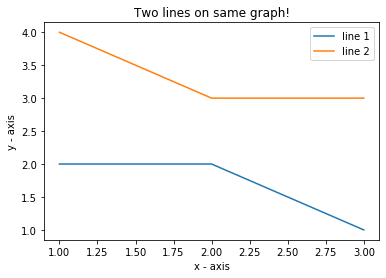

In [16]:
x1 = [1,2,3] 
y1 = [2,2,1] 
# plotting the line 1 points  
plt.plot(x1, y1, label = "line 1") 
  
# line 2 points 
x2 = [1,2,3] 
y2 = [4,3,3] 
# plotting the line 2 points  
plt.plot(x2, y2, label = "line 2") 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
# giving a title to my graph 
plt.title('Two lines on same graph!') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
# plt.show() 
plt.savefig('foo.png', bbox_inches='tight')

In [17]:
import pandas as pd
import numpy as np

In [21]:
episodes = [1,2,3]
success_rate = [0.1,0.4,0.6]
avg_reward = [1,4,10]
data = {
    'episodes': episodes,
    'success_rate': success_rate,
    'avg_reward': avg_reward
}
newpd = pd.DataFrame(data=data)
newpd.to_csv('file.csv')